## Libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
from neo4j import GraphDatabase

## Connect to Neo4J database

In [2]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Croma2023"))
session = driver.session()

## Extractions

### Extract cases

In [3]:
query = f'''Match (e:Event) 
where not e:OnlyKitEvent and e.CaseID is not null
return e.CaseID, e.Activity, e.Nombre, e.KitID, e.Usuario, e.timestamp, e.`Código`, e.NS '''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df = pd.DataFrame(records, columns=columns)
df['e.timestamp'] = pd.to_datetime(df['e.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df.head()

,e.CaseID,e.Activity,e.Nombre,e.KitID,e.Usuario,e.timestamp,e.`Código`,e.NS
0,HNB-OFT.002-10-CN31636,Entrada Material Sucio,Catarata 10,HNB-OFT.002-10,MMF,2022-03-31 20:30:00+00:00,HNB-OFT.002,10
1,HNB-OFT.002-19-CN31637,Entrada Material Sucio,Catarata 19,HNB-OFT.002-19,MMF,2022-03-31 20:30:00+00:00,HNB-OFT.002,19
2,HNB-CPL.002-5-CN31638,Entrada Material Sucio,Mano 05,HNB-CPL.002-5,MMF,2022-03-31 20:30:00+00:00,HNB-CPL.002,5
3,HNB-CG.001-7-CN31639,Entrada Material Sucio,Laparotomia 07,HNB-CG.001-7,MMF,2022-03-31 20:30:00+00:00,HNB-CG.001,7
4,EQP-QUI.OFT.002-3-CN31640,Entrada Material Sucio,FACO INFINITI 03,EQP-QUI.OFT.002-3,MMF,2022-03-31 20:30:00+00:00,EQP-QUI.OFT.002,3


In [4]:
csv_file_path = "/Users/abdalrhman/Documents/bdma-thesis/python/data/27-2_output.csv"
df.to_csv(csv_file_path, index=False)

### Extract processes

In [5]:
query = f'''Match (n:Run)
return distinct(n.activities) as process_cycle, count(n.activities) as repetition
order by count(n.activities) desc
'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
dataframe = pd.DataFrame(records, columns=columns)
dataframe.head()

,process_cycle,repetition
0,Comisionado,12333
1,"Entrada Material Sucio, Cargado en carro L+D, ...",3535
2,"Entrada Material Sucio, Cargado en carro L+D, ...",3457
3,"Montaje, Producción montada, Composición de ca...",2462
4,"Entrada Material Sucio, Cargado en carro L+D, ...",2032


In [6]:
csv_file_path = "/Users/abdalrhman/Documents/bdma-thesis/python/data/27-2_processes_output.csv"
dataframe.to_csv(csv_file_path, index=False)

## Statistics

### Activity duration statistics

In [7]:
query = f'''match (r:Run)
match (start:Event) - [:OBSERVED] -> (c:Class )
match (end:Event) - [:OBSERVED] -> (c2:Class )
match (start) - [:CORR] -> (r)
match (end) - [:CORR] -> (r)
match (start) - [:DF] -> (end)
match (c) - [df:DF_C] ->(c2)
where df.count > 100
return start.Activity, end.Activity, start.timestamp, end.timestamp'''
frame = pd.DataFrame(session.run(query).data())
frame['start.timestamp'] = pd.to_datetime(frame['start.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
frame['end.timestamp'] = pd.to_datetime(frame['end.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
frame['durationDays'] = (frame['end.timestamp'] - frame['start.timestamp']).dt.total_seconds() / 60 / 60 / 24
frame['durationMinutes'] = (frame['end.timestamp'] - frame['start.timestamp']).dt.total_seconds() / 60 
frame.head()

,start.Activity,end.Activity,start.timestamp,end.timestamp,durationDays,durationMinutes
0,Entrada Material Sucio,Cargado en carro L+D,2022-01-24 18:13:00+00:00,2022-01-24 18:19:00+00:00,0.004167,6.0
1,Entrada Material Sucio,Cargado en carro L+D,2022-03-07 13:34:00+00:00,2022-03-07 13:42:00+00:00,0.005556,8.0
2,Cargado en carro L+D,Cargado en carro L+D,2022-01-03 15:25:00+00:00,2022-01-03 15:25:00+00:00,0.000000,0.0
3,Entrada Material Sucio,Cargado en carro L+D,2022-02-04 14:24:00+00:00,2022-02-04 14:44:00+00:00,0.013889,20.0
4,Carga L+D liberada,Cargado en carro L+D,2022-01-11 16:06:00+00:00,2022-01-12 12:03:00+00:00,0.831250,1197.0


In [8]:
grouped = frame.groupby(['start.Activity', 'end.Activity'])['durationMinutes'].describe()
grouped.head()

count        mean          std  \
start.Activity     end.Activity                                             
Carga L+D iniciada Carga L+D iniciada     9717.0    1.912422    14.314242   
                   Carga L+D liberada    13651.0   85.581423    92.113979   
                   Cargado en carro L+D    550.0   29.590909    46.620253   
                   Montaje                 544.0  107.011029  1868.905642   
Carga L+D liberada Carga L+D iniciada      129.0  120.178295   207.200554   

                                         min   25%   50%     75%      max  
start.Activity     end.Activity                                            
Carga L+D iniciada Carga L+D iniciada    0.0   0.0   0.0    0.00    634.0  
                   Carga L+D liberada    0.0  62.0  69.0   77.00    826.0  
                   Cargado en carro L+D  1.0   6.0  18.5   37.75    603.0  
                   Montaje               0.0   4.0  10.0   26.25  43553.0  
Carga L+D liberada Carga L+D iniciada    1.0   8.0  23.0  141.00   1391.0

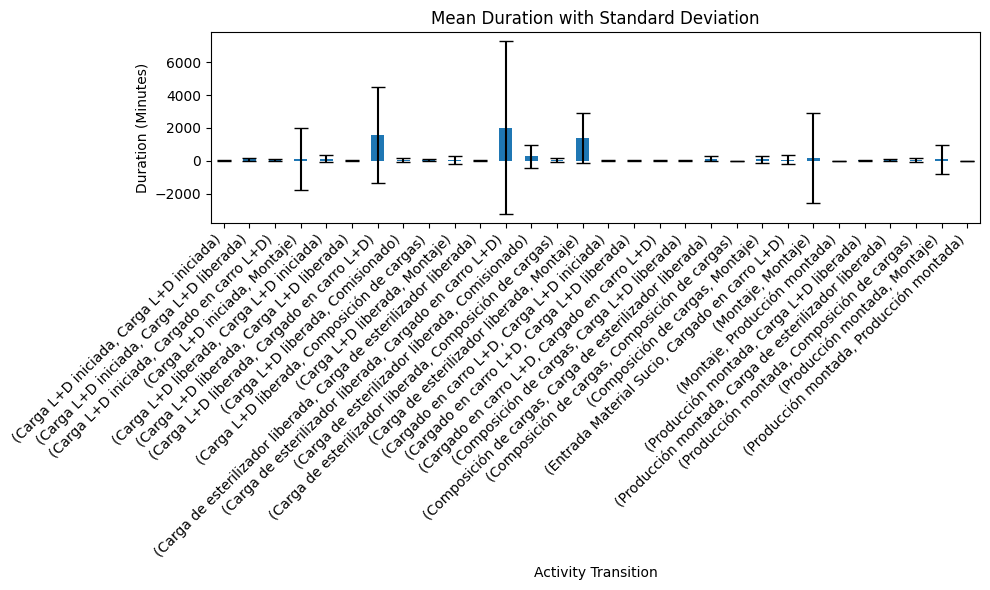

In [9]:

# Plotting mean with error bars (standard deviation)
plt.figure(figsize=(10, 6))
grouped['mean'].plot(kind='bar', yerr=grouped['std'], capsize=5)
plt.xlabel('Activity Transition')
plt.ylabel('Duration (Minutes)')
plt.title('Mean Duration with Standard Deviation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



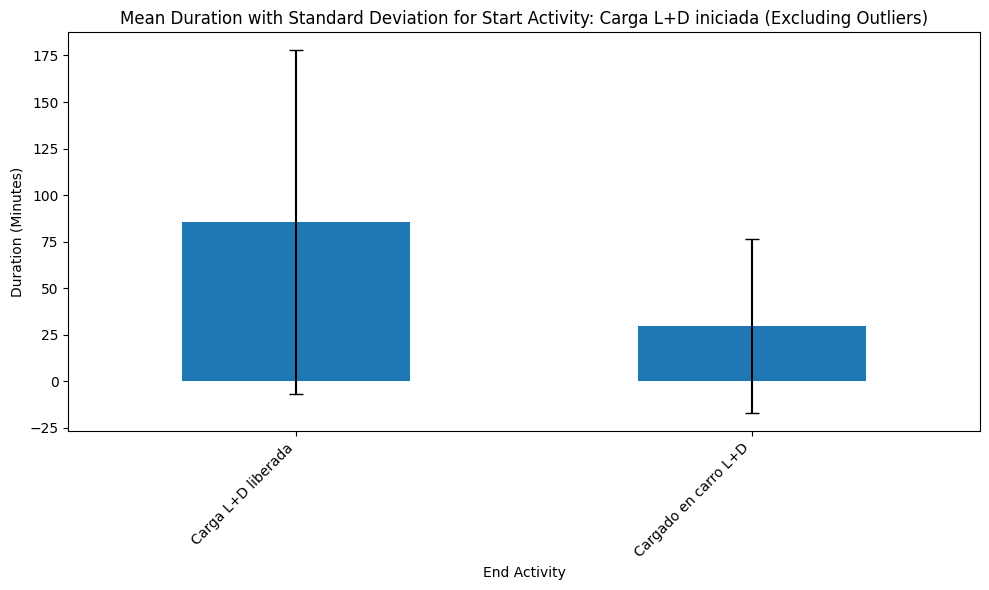

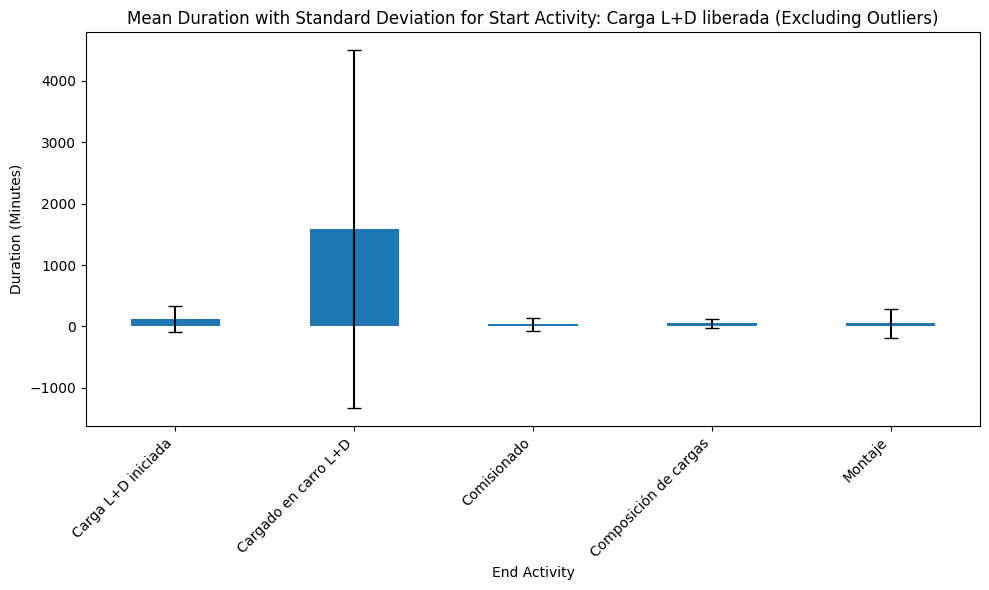

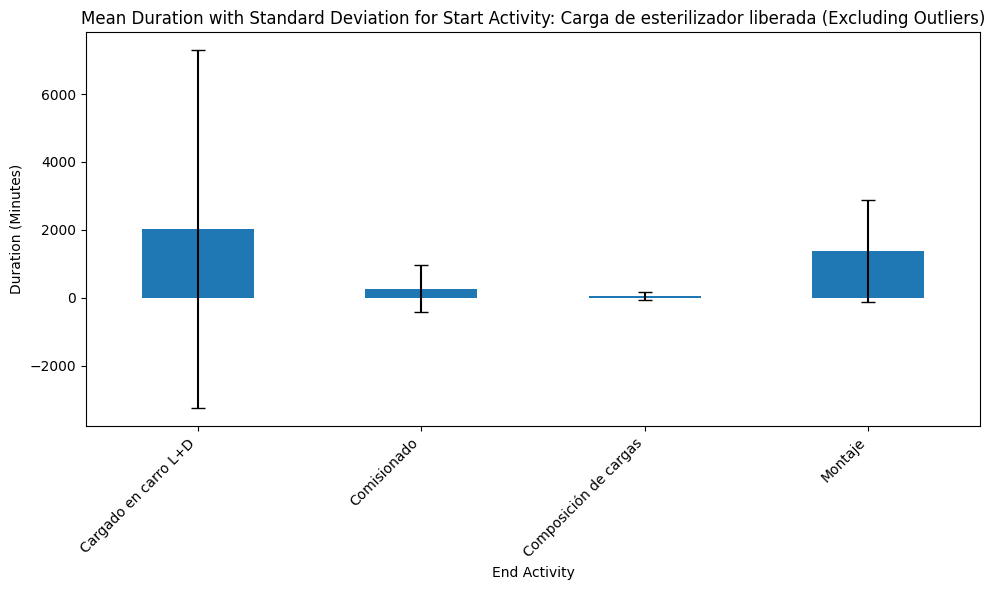

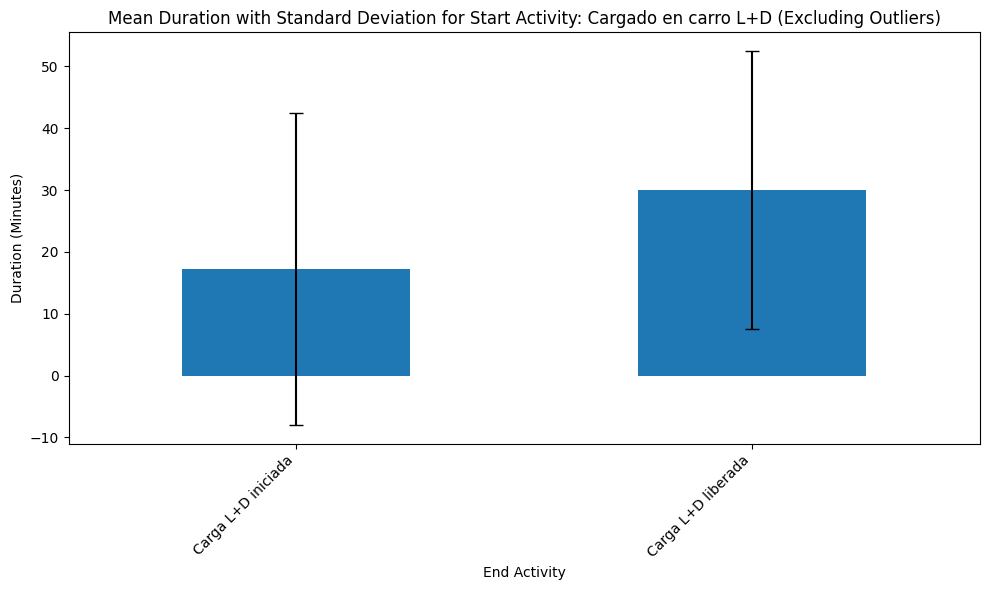

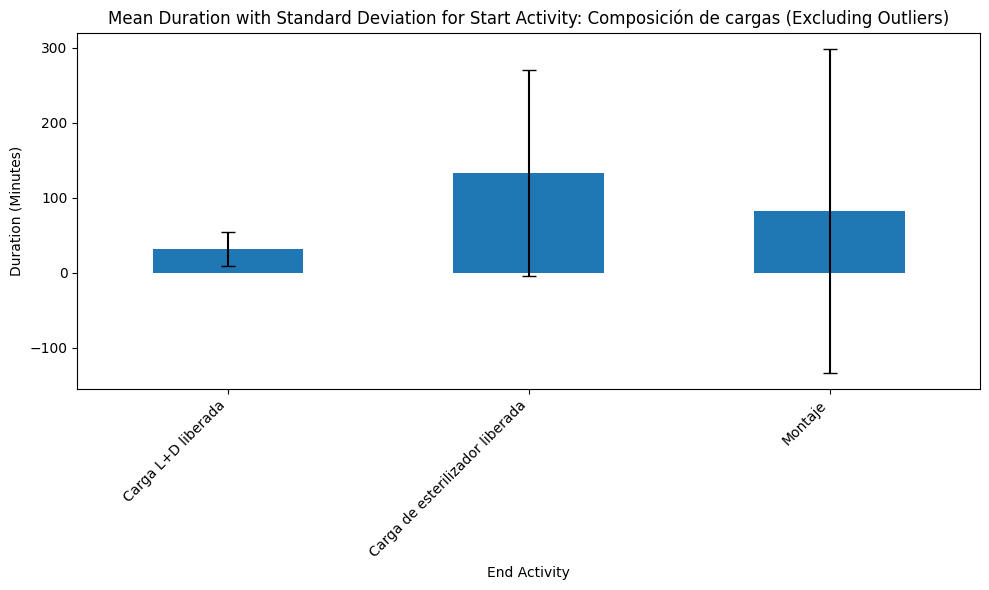

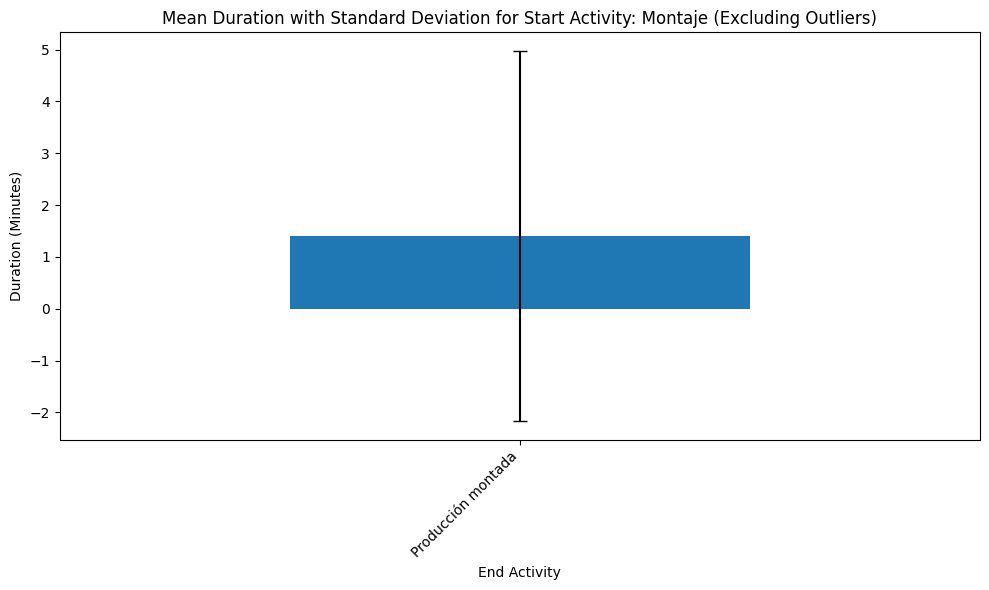

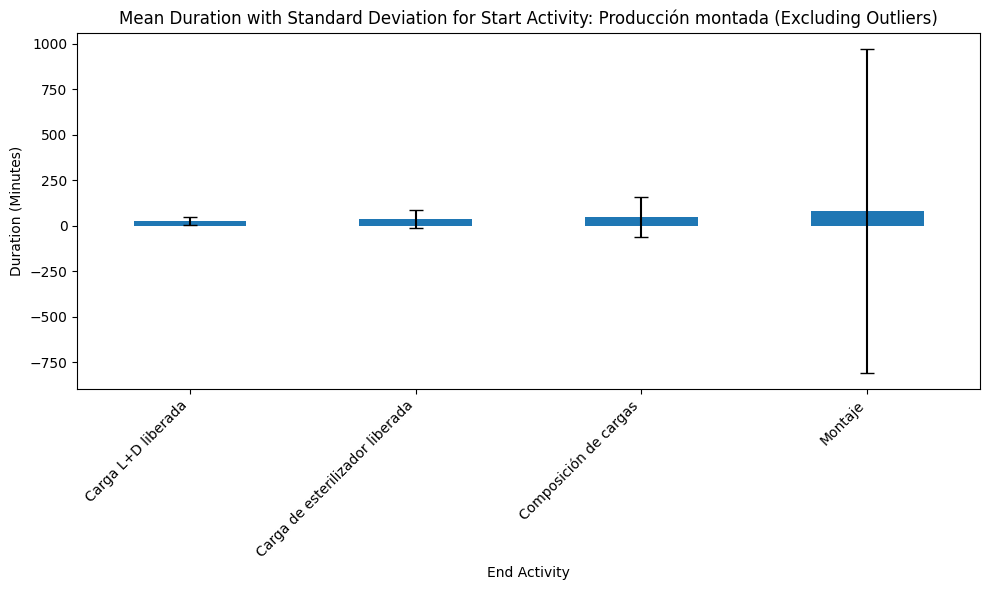

In [10]:
start_activities = grouped.index.get_level_values('start.Activity').unique()

# Plot each start activity separately
for start_activity in start_activities:
    # Filter data for the current start activity and exclude outliers
    start_activity_data = grouped.loc[start_activity]
    Q1 = start_activity_data['25%']
    Q3 = start_activity_data['75%']
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    start_activity_data_filtered = start_activity_data[(start_activity_data['mean'] >= lower_bound) & (start_activity_data['mean'] <= upper_bound)]

    if not start_activity_data_filtered.empty:
    # Plotting mean with error bars (standard deviation) for filtered data
        plt.figure(figsize=(10, 6))
        start_activity_data_filtered['mean'].plot(kind='bar', yerr=start_activity_data_filtered['std'], capsize=5)
        plt.xlabel('End Activity')
        plt.ylabel('Duration (Minutes)')
        plt.title(f'Mean Duration with Standard Deviation for Start Activity: {start_activity} (Excluding Outliers)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


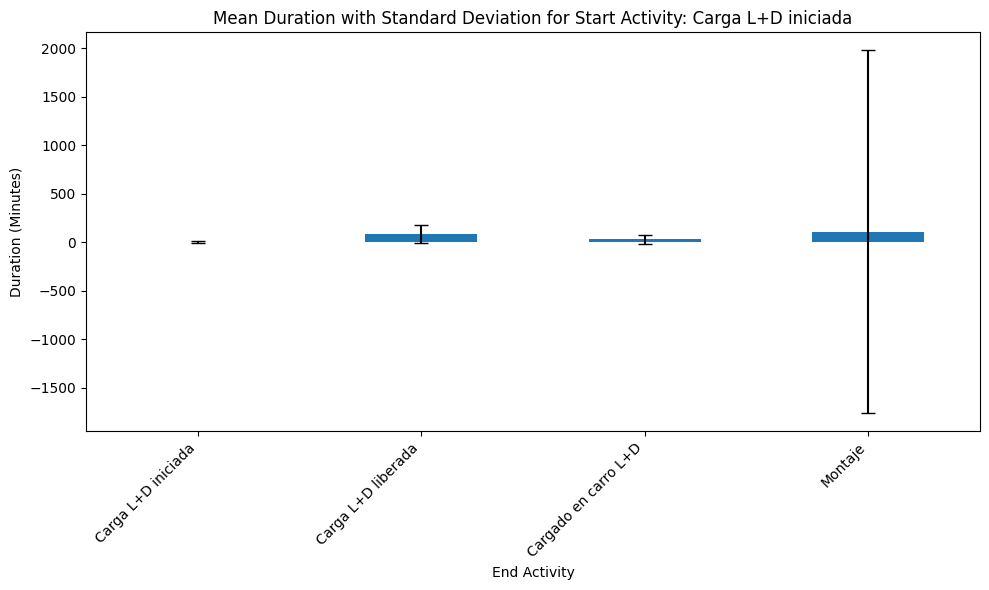

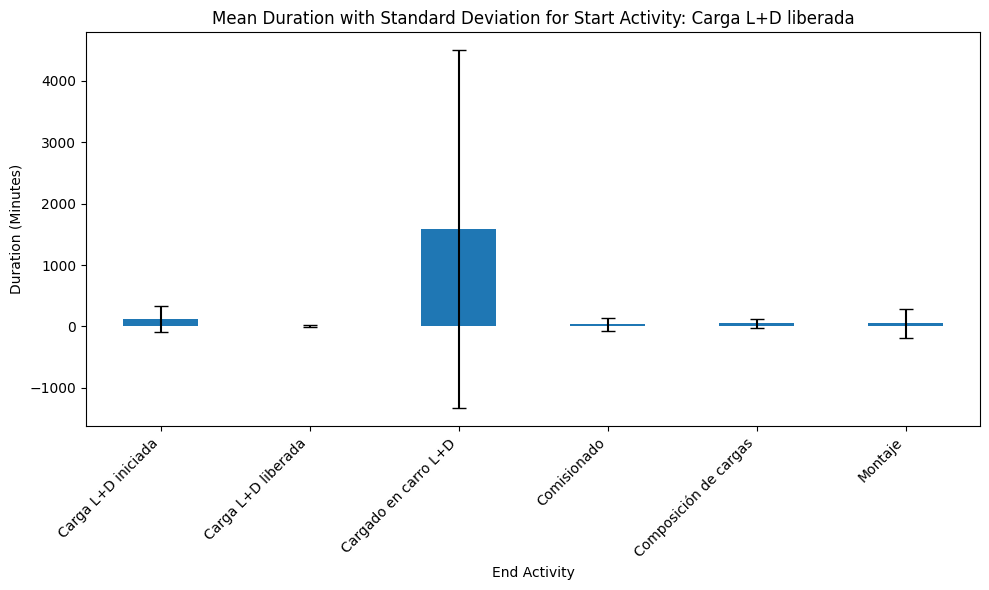

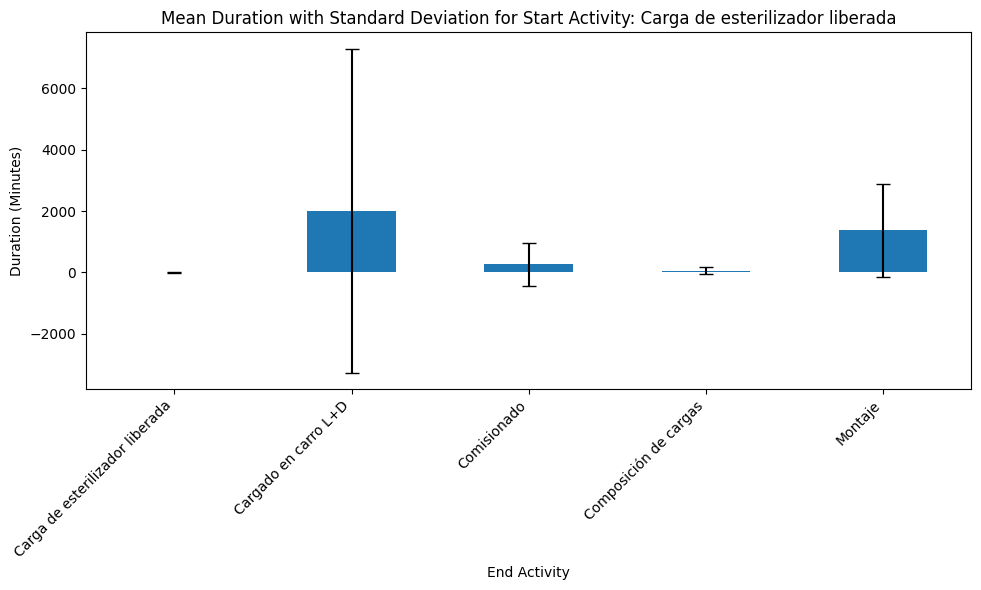

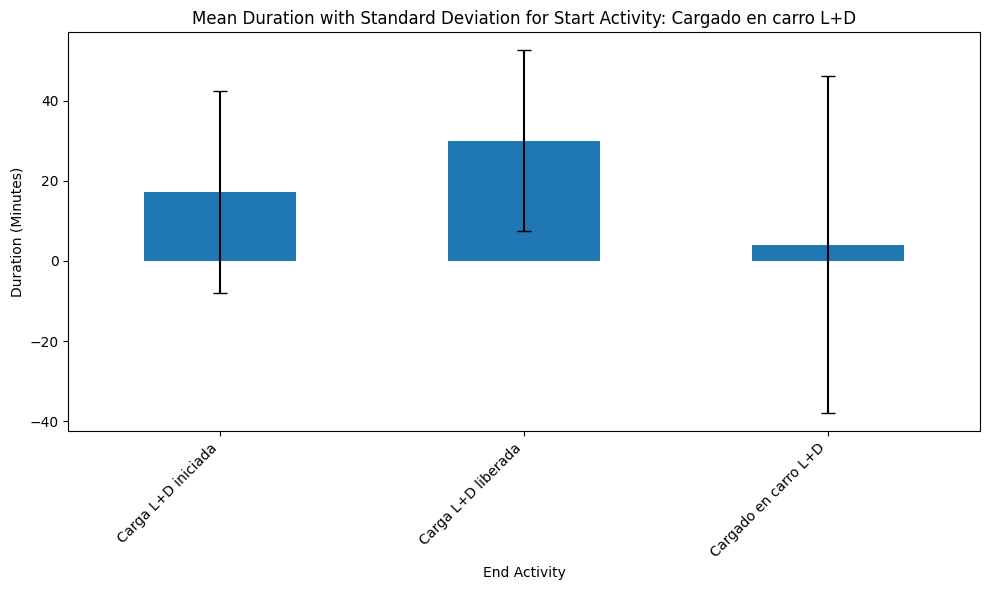

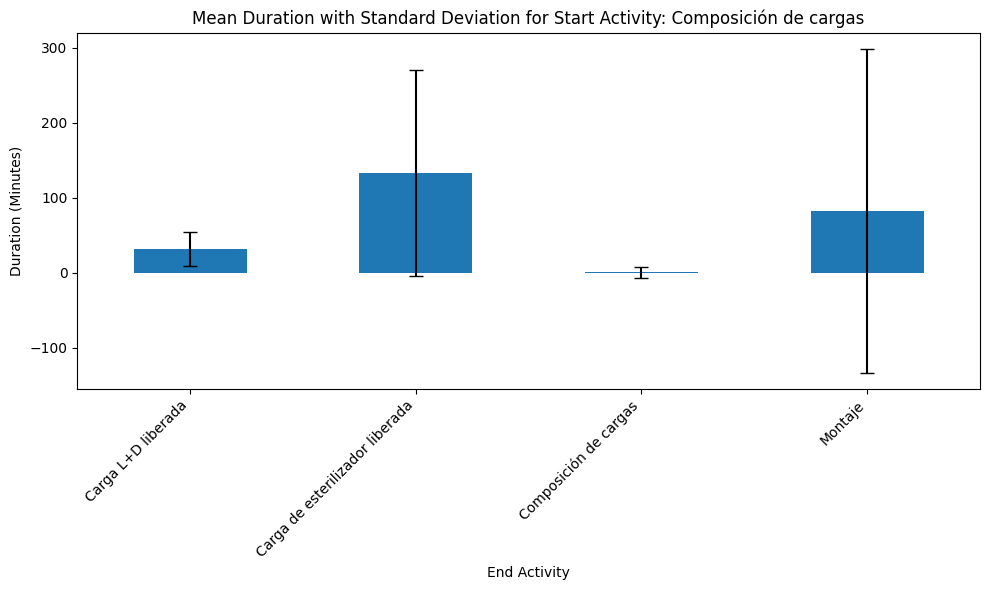

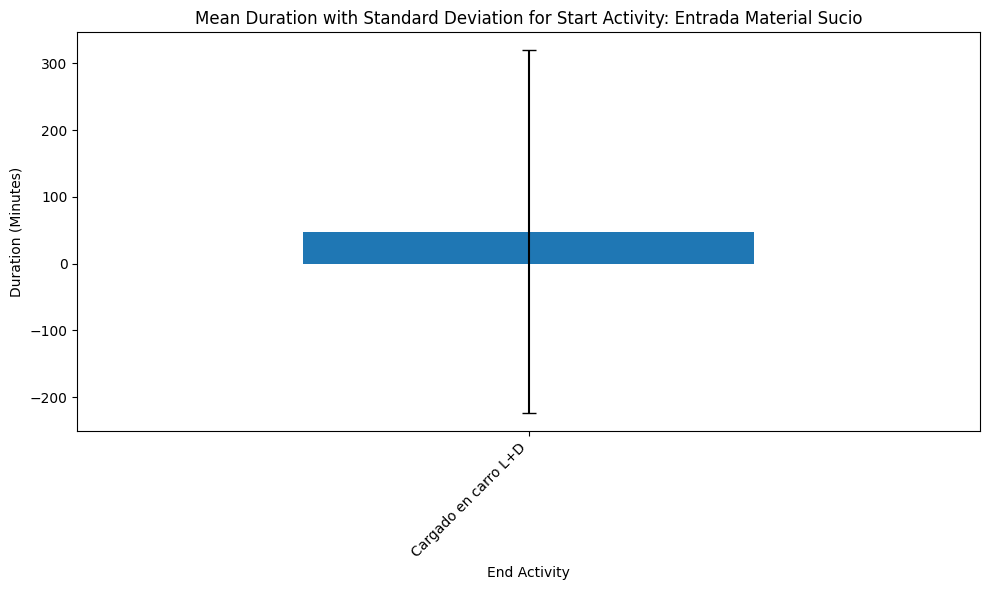

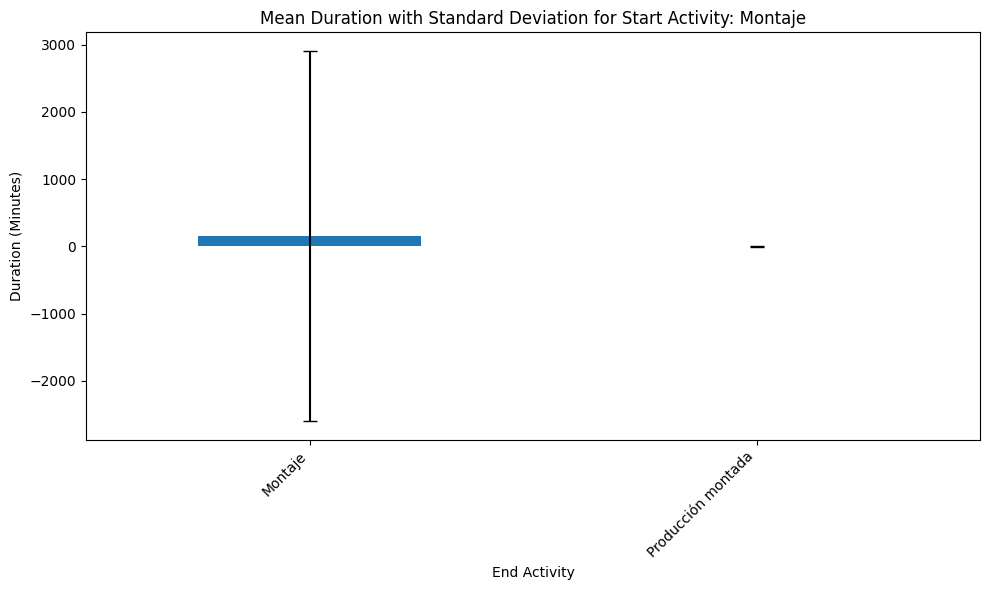

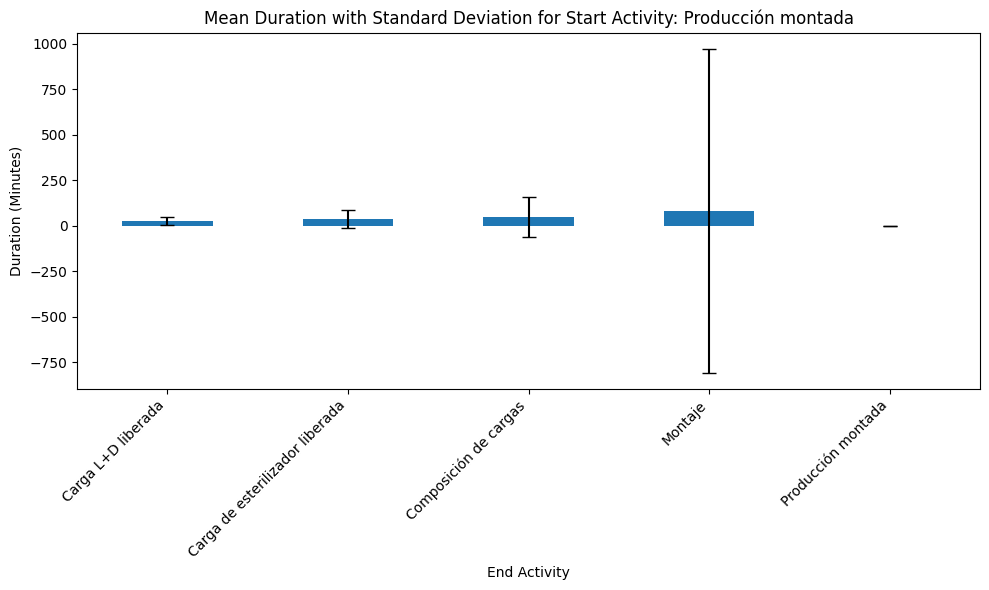

In [11]:
start_activities = grouped.index.get_level_values('start.Activity').unique()

# Plot each start activity separately
for start_activity in start_activities:
    # Filter data for the current start activity
    start_activity_data = grouped.loc[start_activity]

    # Plotting mean with error bars (standard deviation)
    plt.figure(figsize=(10, 6))
    start_activity_data['mean'].plot(kind='bar', yerr=start_activity_data['std'], capsize=5)
    plt.xlabel('End Activity')
    plt.ylabel('Duration (Minutes)')
    plt.title(f'Mean Duration with Standard Deviation for Start Activity: {start_activity}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Process duration based on the type of sterilization

In [24]:
query = f'''MATCH (n:SterilizationMachine {{type : "Low Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
WHERE not e:OnlyKitEvent
Match (e) - [:CORR] -> (r:Run)
WHERE NOT (r) <- [:CORR] - (:Event)-[:STERILIZED_IN]->(:SterilizationMachine {{type : "High Temperature Sterilization"}})
return distinct(r.CaseID), r.durationInMinutes'''
session.run(query).data()

[{'(r.CaseID)': 'EXT-QUI.005-0-CN26035', 'r.durationInMinutes': 11434.0},
 {'(r.CaseID)': 'EXT-QUI.005-0-CN15856',
  'r.durationInMinutes': 523.0000000000001},
 {'(r.CaseID)': 'HGY-ELECT.SUELTO-0-CN18447', 'r.durationInMinutes': 392.0},
 {'(r.CaseID)': 'EXT-QUI.006-0-CN26229', 'r.durationInMinutes': 5046.0},
 {'(r.CaseID)': 'HGY-ELECT.SUELTO-0-CN7833',
  'r.durationInMinutes': 267.00000000000006},
 {'(r.CaseID)': 'EXT-QUI.005-0-CN32818', 'r.durationInMinutes': nan},
 {'(r.CaseID)': 'EQP-DAVINCI.006-2-CN15029', 'r.durationInMinutes': 390.0},
 {'(r.CaseID)': 'EXT-QUI.005-0-CN32818', 'r.durationInMinutes': nan},
 {'(r.CaseID)': 'EXT-QUI.006-0-CN1238', 'r.durationInMinutes': 1459.0},
 {'(r.CaseID)': 'EXT-QUI.005-0-CN32818', 'r.durationInMinutes': nan},
 {'(r.CaseID)': 'HGY-ELECT.SUELTO-0-CN17163', 'r.durationInMinutes': 226.0},
 {'(r.CaseID)': 'EQP-QUI.BTE-2-CN32002', 'r.durationInMinutes': nan},
 {'(r.CaseID)': 'EXT-QUI.KIRSCHNER-0-CN28819', 'r.durationInMinutes': 4571.0},
 {'(r.CaseID)':

In [13]:
query = f'''MATCH (n:SterilizationMachine {{type : "Low Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
where not e:OnlyKitEvent
Match (e) - [:CORR] -> (r:Run)
Match (e2:Event) - [c:CORR] -> (r)
MATCH (n2:SterilizationMachine {{type : "High Temperature Sterilization"}}) <- [si:STERILIZED_IN] - (e2)
return distinct(r.CaseID), r.durationInMinutes'''
session.run(query).data()

In [14]:
query = f'''MATCH (n:SterilizationMachine {{type : "High Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
where not e:OnlyKitEvent
Match (e) - [:CORR] -> (r:Run)
WHERE NOT (r) <- [:CORR] - (:Event)-[:STERILIZED_IN]->(:SterilizationMachine {{type : "Low Temperature Sterilization"}})
return distinct(r.CaseID), r.durationInMinutes'''
session.run(query).data()

In [15]:
query = f'''MATCH (n:SterilizationMachine {{type : "Low Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
            where not e:OnlyKitEvent
            Match (e) - [:CORR] -> (r:Run)
            Match (e2:Event) - [c:CORR] -> (r)
            MATCH (n2:SterilizationMachine {{type : "High Temperature Sterilization"}}) <- [si:STERILIZED_IN] - (e2)
            with distinct(r.durationInMinutes) as durationList
            with apoc.agg.statistics(durationList) as dualTempStat

            MATCH (n:SterilizationMachine {{type : "Low Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
            WHERE not e:OnlyKitEvent
            Match (e) - [:CORR] -> (r:Run)
            WHERE NOT (r) <- [:CORR] - (:Event)-[:STERILIZED_IN]->(:SterilizationMachine {{type : "High Temperature Sterilization"}})
            with distinct(r.durationInMinutes) as durationList, dualTempStat
            with apoc.agg.statistics(durationList) as lowTempStat, dualTempStat

            MATCH (n:SterilizationMachine {{type : "High Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
            WHERE not e:OnlyKitEvent
            Match (e) - [:CORR] -> (r:Run)
            WHERE NOT (r) <- [:CORR] - (:Event)-[:STERILIZED_IN]->(:SterilizationMachine {{type : "Low Temperature Sterilization"}})
            with distinct(r.durationInMinutes) as durationList, lowTempStat, dualTempStat
            with apoc.agg.statistics(durationList) as highTempStat, lowTempStat, dualTempStat

            return lowTempStat, dualTempStat, highTempStat
            '''

session.run(query).data()

[{'lowTempStat': {'total': 124,
   'min': 40.0,
   'minNonZero': 40.0,
   'max': 12623.0,
   'mean': 1062.4143972089214,
   '0.5': 365.001708984375,
   '0.99': 11434.062255859375,
   '0.75': 1095.007568359375,
   '0.9': 2987.015380859375,
   '0.95': 4571.031005859375,
   'stdev': 1960.3532751847322},
  'dualTempStat': {'total': 507,
   'min': 225.0,
   'minNonZero': 225.0,
   'max': 21818.0,
   'mean': 68.67081946499013,
   '0.5': 0.0,
   '0.99': 445.0009765625,
   '0.75': 0.0,
   '0.9': 0.0,
   '0.95': 0.0,
   'stdev': 1042.228502676582},
  'highTempStat': {'total': 3105,
   'min': nan,
   'minNonZero': 26.0,
   'max': nan,
   'mean': 714.7501298151923,
   '0.5': 0.0,
   '0.99': 13083.062377929688,
   '0.75': 379.0018310546875,
   '0.9': 1458.0076904296875,
   '0.95': 3190.0155029296875,
   'stdev': 2861.153129805878}}]

## Extractions

### Extract kits based on the sterilization type

In [16]:
query = f'''MATCH (n:SterilizationMachine {{type : "Low Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
            WHERE not e:OnlyKitEvent
            Match (e) - [:CORR] -> (r:Run)
            match (r) <- [:HAS_RUN] - (en:Entity)
            match (en) <- [:HAS_UNIT] - (k:Kit)
            Match (e2:Event) - [c:CORR] -> (r)
            MATCH (n2:SterilizationMachine {{type : "High Temperature Sterilization"}}) <- [si:STERILIZED_IN] - (e2)
            with distinct(k.ID) as dualTempStatKit
            return collect(dualTempStatKit) as dualTempStatKitList
        '''
session.run(query).data()

[{'dualTempStatKitList': ['HGY-ELECT.SUELTO',
   'HGY-QUI.NEUR.SUELTO',
   'EXT-CISTOSCOPIAS',
   'EXT-QUI.004',
   'HGY-CCEE.SUELTO',
   'HGY-QUI.CPL.SUELTO',
   'HGY-QUI.URO.SUELTO',
   'HGY-NEO.SUELTO',
   'EXT-QUI.FIADOR',
   'HGY-QUI.GIN.SUELTO',
   'HGY-QUI.OFT.CAJA']}]

In [17]:
query = f'''MATCH (n:SterilizationMachine {{type : "Low Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
            Match (e) - [:CORR] -> (r:Run)
            match (r) - [:HAS_RUN] -> (en:Entity)
            match (en) <- [:HAS_UNIT] - (k:Kit)
            WHERE NOT (k) - [:HAS_UNIT] -> (:Entity) - [:HAS_RUN] -> (:Run) <- [:CORR] - (:Event)-[:STERILIZED_IN]->(:SterilizationMachine {{type : "High Temperature Sterilization"}})
            with distinct(k.ID) as lowTempStatKit
            return collect(lowTempStatKit) as lowTempStatKitList
            '''
session.run(query).data()

[{'lowTempStatKitList': []}]

In [18]:
query = f'''MATCH (n:SterilizationMachine {{type : "High Temperature Sterilization"}}) <- [:STERILIZED_IN] - (e:Event)
            WHERE not e:OnlyKitEvent
            Match (e) - [:CORR] -> (r:Run)
            match (r) <- [:HAS_RUN] - (en:Entity)
            match (en) <- [:HAS_UNIT] - (k:Kit)
            WHERE NOT (k) - [:HAS_UNIT] -> (:Entity) - [:HAS_RUN] -> (:Run) <- [:CORR] - (:Event)-[:STERILIZED_IN]->(:SterilizationMachine {{type : "Low Temperature Sterilization"}})
            with distinct(k.ID) as highTempStatKit
            return collect(highTempStatKit) as highTempStatKitList'''
session.run(query).data()

[{'highTempStatKitList': ['HGY-QUI.ORLSUELTO',
   'EXT-QUI.495NCS',
   'HUBU-HOS.CGA.BM065R',
   'EXT-QUI.NAV_CRANEAL',
   'HUBU-CCEE.ORL.BD050R',
   'HGY-PTM.SUELTO',
   'HUBU-HOS.GINE.BC346R',
   'HUBU-HOS.DOM.BD559R',
   'HUBU-CCEE.ORL.BD880R',
   'EXT-UCI.MAQUET',
   'DEP-QUI.TRA.S&N',
   'EXT-HOS.007',
   'EXT-QUI.012',
   'HUBU-HOS.DIG.OM044R',
   'EXT-QUI.OMS800.02',
   'HUBU-CCEE.DER.BC110R',
   'HUBU-QUI.CPL.SL018R',
   'HGY-PFUNC.SUELTO',
   'HUBU-QUI.GIN.JG524R',
   'HGY-UCIA.SUELTO',
   'HUBU-TR.008',
   'HUBU-HOS.SUELTO',
   'HUBU-CCEE.GIN.BH646R',
   'HNB-CPL.002',
   'HUBU-CCEE.GIN.BC604R',
   'HUBU-QUI.URO.002',
   'EQP-QUI.CG.OPT',
   'HUBU-CCEE.ORL.OK035R',
   'EQP-QUI.TRA.OPT',
   'EXT-QUI.011',
   'HGY-QUI.ORL.CAJA',
   'HNB-URO.001',
   'EXT-HOS.002',
   'HUBU-HOS.ORL.BD222R',
   'HUBU-QUI.TR.BV248R',
   'HUBU-QUI.HEMO.JG523R',
   'HGY-HEMO.SUELTO',
   'HUBU-HOS.URPA.BH442R',
   'HNB-CG.003',
   'HNB-CPL.003',
   'EQP-QUI.OFT.002',
   'HUBU-CCEE.GIN.AN711R',
   'EX

### Extract total processing time

In [19]:
query = f'''Match (k:Kit) - [:HAS_UNIT] -> (e:Entity)
match (e) - [:HAS_RUN] -> (r:Run)
return k.ID, k.numberOfUnits, e.ID, e.numberOfCycles, r.CaseID, r.start_timestamp, r.end_timestamp, collect(r.activities)'''

frame = pd.DataFrame(session.run(query).data())
frame['r.start_timestamp'] = pd.to_datetime(frame['r.start_timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
frame['r.end_timestamp'] = pd.to_datetime(frame['r.end_timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
frame['durationInDays'] = (frame['r.end_timestamp'] - frame['r.start_timestamp']).dt.total_seconds() / 60 / 60 / 24
frame['durationInHours'] = (frame['r.end_timestamp'] - frame['r.start_timestamp']).dt.total_seconds() / 60 / 60 
frame['durationInMinutes'] = (frame['r.end_timestamp'] - frame['r.start_timestamp']).dt.total_seconds() / 60 
csv_file_path = "/Users/abdalrhman/Documents/preparationphase/tableau/case_duration.csv"
frame.to_csv(csv_file_path, index=False)
frame.head()

,k.ID,k.numberOfUnits,e.ID,e.numberOfCycles,r.CaseID,r.start_timestamp,r.end_timestamp,collect(r.activities),durationInDays,durationInHours,durationInMinutes
0,HNB-OFT.002,19,HNB-OFT.002-10,24,HNB-OFT.002-10-CN31495,NaT,NaT,"[Entrada Material Sucio, Cargado en carro L+D,...",NaN,NaN,NaN
1,HNB-OFT.002,19,HNB-OFT.002-10,24,HNB-OFT.002-10-CN22250,NaT,NaT,"[Entrada Material Sucio, Cargado en carro L+D,...",NaN,NaN,NaN
2,HNB-OFT.002,19,HNB-OFT.002-10,24,HNB-OFT.002-10-CN29542,NaT,NaT,"[Entrada Material Sucio, Cargado en carro L+D,...",NaN,NaN,NaN
3,HNB-OFT.002,19,HNB-OFT.002-10,24,HNB-OFT.002-10-CN29927,NaT,NaT,"[Entrada Material Sucio, Cargado en carro L+D,...",NaN,NaN,NaN
4,HNB-OFT.002,19,HNB-OFT.002-10,24,HNB-OFT.002-10-CN16520,NaT,NaT,"[Entrada Material Sucio, Cargado en carro L+D,...",NaN,NaN,NaN


### Extract kits based on the washing machine

In [20]:
query = '''MATCH (w:WashingMachine {machine: "Jupiter"}) <- [:WASHED_IN] - (e:Event)
            WHERE not e:OnlyKitEvent
            Match (e) - [:CORR] -> (r:Run)
            match (r) <- [:HAS_RUN] - (en:Entity)
            match (en) <- [:HAS_UNIT] - (k:Kit)
            WHERE NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 1"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 2"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 3"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 4"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Caducado"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Lavado"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Reposicion"})
            with distinct(k.ID) as kitsWashedInJupiter, en.ID as ent
            return kitsWashedInJupiter, collect(distinct(ent)) as entities'''
session.run(query).data()

[{'kitsWashedInJupiter': 'HNB-ORL.011', 'entities': ['HNB-ORL.011-2']},
 {'kitsWashedInJupiter': 'CONT-QUI.TRA', 'entities': ['CONT-QUI.TRA-1']},
 {'kitsWashedInJupiter': 'HNB-CG.008',
  'entities': ['HNB-CG.008-3', 'HNB-CG.008-4']},
 {'kitsWashedInJupiter': 'HNB-URO.002', 'entities': ['HNB-URO.002-3']},
 {'kitsWashedInJupiter': 'HNB-CG.001',
  'entities': ['HNB-CG.001-12', 'HNB-CG.001-9']},
 {'kitsWashedInJupiter': 'HNB-CPL.002',
  'entities': ['HNB-CPL.002-5', 'HNB-CPL.002-9']},
 {'kitsWashedInJupiter': 'HNB-CG.003', 'entities': ['HNB-CG.003-7']},
 {'kitsWashedInJupiter': 'CONT-PARTOS', 'entities': ['CONT-PARTOS-2']},
 {'kitsWashedInJupiter': 'HUBU-ORL.023', 'entities': ['HUBU-ORL.023-1']},
 {'kitsWashedInJupiter': 'HUBU-GIN.020', 'entities': ['HUBU-GIN.020-6']},
 {'kitsWashedInJupiter': 'CONT-QUI.URG', 'entities': ['CONT-QUI.URG-1']},
 {'kitsWashedInJupiter': 'HNB-GIN.003', 'entities': ['HNB-GIN.003-5']},
 {'kitsWashedInJupiter': 'HNB-CV.007', 'entities': ['HNB-CV.007-1']}]

In [21]:
query = '''MATCH (w:WashingMachine {machine: "Esclusa Caducado"}) <- [:WASHED_IN] - (e:Event)
            WHERE not e:OnlyKitEvent
            Match (e) - [:CORR] -> (r:Run)
            match (r) <- [:HAS_RUN] - (en:Entity)
            match (en) <- [:HAS_UNIT] - (k:Kit)
            WHERE NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 1"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 2"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 3"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 4"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Jupiter"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Lavado"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Reposicion"})
            with distinct(k.ID) as kitsWashedInEsclusaCaducado, en.ID as ene
            return kitsWashedInEsclusaCaducado, collect(distinct(ene)) as entities'''
session.run(query).data()

[{'kitsWashedInEsclusaCaducado': 'HUBU-ORL.017',
  'entities': ['HUBU-ORL.017-1', 'HUBU-ORL.017-3']},
 {'kitsWashedInEsclusaCaducado': 'EQP-DAVINCI.019',
  'entities': ['EQP-DAVINCI.019-1']},
 {'kitsWashedInEsclusaCaducado': 'HNB-NC.029', 'entities': ['HNB-NC.029-1']},
 {'kitsWashedInEsclusaCaducado': 'HNB-OFT.009', 'entities': ['HNB-OFT.009-1']},
 {'kitsWashedInEsclusaCaducado': 'HUBU-GIN.023',
  'entities': ['HUBU-GIN.023-2']},
 {'kitsWashedInEsclusaCaducado': 'DEP-QUI.TRA.ZIMMER',
  'entities': ['DEP-QUI.TRA.ZIMMER-54',
   'DEP-QUI.TRA.ZIMMER-52',
   'DEP-QUI.TRA.ZIMMER-53',
   'DEP-QUI.TRA.ZIMMER-51']},
 {'kitsWashedInEsclusaCaducado': 'HUBU-HOS.DER.020',
  'entities': ['HUBU-HOS.DER.020-2', 'HUBU-HOS.DER.020-1']},
 {'kitsWashedInEsclusaCaducado': 'HNB-NC.018', 'entities': ['HNB-NC.018-1']},
 {'kitsWashedInEsclusaCaducado': 'EQP-DAVINCI.016',
  'entities': ['EQP-DAVINCI.016-1']},
 {'kitsWashedInEsclusaCaducado': 'EQP-QUI.OFT.003',
  'entities': ['EQP-QUI.OFT.003-4']},
 {'kitsWashed

In [22]:
query = '''MATCH (w:WashingMachine {machine: "Esclusa Lavado"}) <- [:WASHED_IN] - (e:Event)
            WHERE not e:OnlyKitEvent
            Match (e) - [:CORR] -> (r:Run)
            match (r) <- [:HAS_RUN] - (en:Entity)
            match (en) <- [:HAS_UNIT] - (k:Kit)
            WHERE NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 1"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 2"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 3"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 4"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Jupiter"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Caducado"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Reposicion"})
            with distinct(k.ID) as kitsWashedInEsclusaLavado, en.ID as ene
            return kitsWashedInEsclusaLavado, collect(distinct(ene)) as entities'''
session.run(query).data()

[{'kitsWashedInEsclusaLavado': 'HNB-CG.003',
  'entities': ['HNB-CG.003-5', 'HNB-CG.003-3']},
 {'kitsWashedInEsclusaLavado': 'DEP-QUI.TRA.CERAVER',
  'entities': ['DEP-QUI.TRA.CERAVER-18',
   'DEP-QUI.TRA.CERAVER-16',
   'DEP-QUI.TRA.CERAVER-17',
   'DEP-QUI.TRA.CERAVER-15']},
 {'kitsWashedInEsclusaLavado': 'EQP-POLIV.001',
  'entities': ['EQP-POLIV.001-3', 'EQP-POLIV.001-1']},
 {'kitsWashedInEsclusaLavado': 'EQP-QUI.URO.016',
  'entities': ['EQP-QUI.URO.016-1', 'EQP-QUI.URO.016-2']},
 {'kitsWashedInEsclusaLavado': 'EQP-QUI.BTE',
  'entities': ['EQP-QUI.BTE-2', 'EQP-QUI.BTE-3']},
 {'kitsWashedInEsclusaLavado': 'EXT-QUI.ORL.MEDTRONI',
  'entities': ['EXT-QUI.ORL.MEDTRONI-0']},
 {'kitsWashedInEsclusaLavado': 'EXT-QUI.URO.009',
  'entities': ['EXT-QUI.URO.009-1']},
 {'kitsWashedInEsclusaLavado': 'EXT-QUI.CG.006',
  'entities': ['EXT-QUI.CG.006-1']},
 {'kitsWashedInEsclusaLavado': 'EXT-CISTOSCOPIAS',
  'entities': ['EXT-CISTOSCOPIAS-0']},
 {'kitsWashedInEsclusaLavado': 'EXT-QUI.TRA.005',
 

In [23]:
query = '''MATCH (w:WashingMachine {machine: "Esclusa Reposicion"}) <- [:WASHED_IN] - (e:Event)
            WHERE not e:OnlyKitEvent
            Match (e) - [:CORR] -> (r:Run)
            match (r) <- [:HAS_RUN] - (en:Entity)
            match (en) <- [:HAS_UNIT] - (k:Kit)
            WHERE NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 1"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 2"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 3"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Lavadora 4"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Jupiter"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Lavado"})
            and NOT (r) <- [:CORR] - (:Event)-[:WASHED_IN]->(:WashingMachine {machine: "Esclusa Caducado"})
            with distinct(k.ID) as kitsWashedInEsclusaReposicion, en.ID as ene
            return kitsWashedInEsclusaReposicion, collect(distinct(ene)) as entities'''
session.run(query).data()

[{'kitsWashedInEsclusaReposicion': 'EQP-QUI.OFT.003',
  'entities': ['EQP-QUI.OFT.003-2', 'EQP-QUI.OFT.003-1', 'EQP-QUI.OFT.003-3']},
 {'kitsWashedInEsclusaReposicion': 'HUBU-ORL.027',
  'entities': ['HUBU-ORL.027-1']},
 {'kitsWashedInEsclusaReposicion': 'DEP-QUI.TRA.ZIMMER',
  'entities': ['DEP-QUI.TRA.ZIMMER-53']},
 {'kitsWashedInEsclusaReposicion': 'HNB-OFT.002',
  'entities': ['HNB-OFT.002-10', 'HNB-OFT.002-6', 'HNB-OFT.002-8']},
 {'kitsWashedInEsclusaReposicion': 'HNB-TR.010', 'entities': ['HNB-TR.010-1']},
 {'kitsWashedInEsclusaReposicion': 'DEP-QUI.TRA.STRYK',
  'entities': ['DEP-QUI.TRA.STRYK-56', 'DEP-QUI.TRA.STRYK-55']},
 {'kitsWashedInEsclusaReposicion': 'HNB-CPL.016',
  'entities': ['HNB-CPL.016-3']},
 {'kitsWashedInEsclusaReposicion': 'HNB-CPL.005',
  'entities': ['HNB-CPL.005-2']},
 {'kitsWashedInEsclusaReposicion': 'HNB-CG.001', 'entities': ['HNB-CG.001-4']},
 {'kitsWashedInEsclusaReposicion': 'HUBU-TR.003',
  'entities': ['HUBU-TR.003-4']},
 {'kitsWashedInEsclusaReposic